## Imports

In [6]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

## Loading in Stanford Dogs Dataset (SDD)

In [10]:
import shutil

# Remove all cached KaggleHub datasets
shutil.rmtree("/root/.cache/kagglehub/datasets/jessicali9530", ignore_errors=True)
print("KaggleHub cache deleted.")


KaggleHub cache deleted.


In [11]:
import kagglehub

# Download latest version
path_sdd = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

print("Path to dataset files:", path_sdd)

100%|██████████| 750M/750M [00:07<00:00, 105MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2


In [12]:
import os

#dataset_path = "/root/.cache/kagglehub/datasets/jessicali9530/stanford-dogs-dataset/versions/2"
dataset_path_sdd = path_sdd

# List the dataset files
print("Files and folders in dataset directory:")
print(os.listdir(dataset_path_sdd))


Files and folders in dataset directory:
['annotations', 'images']


In [13]:
train_dir = os.path.join(dataset_path_sdd, "images", "Images")  # Correcting path
print("Contents inside 'images/Images' folder:")
print(os.listdir(train_dir)[:10])  # Should print 10 breed folders


Contents inside 'images/Images' folder:
['n02102040-English_springer', 'n02096294-Australian_terrier', 'n02112137-chow', 'n02096177-cairn', 'n02115641-dingo', 'n02085620-Chihuahua', 'n02092002-Scottish_deerhound', 'n02109525-Saint_Bernard', 'n02102973-Irish_water_spaniel', 'n02110063-malamute']


In [14]:
num_classes = len(os.listdir(train_dir))
print(f"Number of dog breeds (classes): {num_classes}")


Number of dog breeds (classes): 120


In [15]:
image_count = sum([len(files) for _, _, files in os.walk(train_dir)])
print(f"Total number of images: {image_count}")


Total number of images: 20580


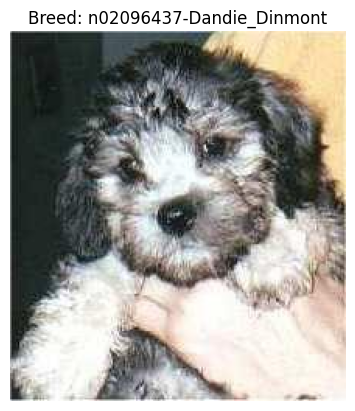

In [16]:
import random
from PIL import Image

# Select a random breed folder
random_breed = random.choice(os.listdir(train_dir))
breed_path = os.path.join(train_dir, random_breed)

# Select a random image from the breed folder
random_image = random.choice(os.listdir(breed_path))
image_path = os.path.join(breed_path, random_image)

# Fixing: Ensure it's a file, not a directory
while os.path.isdir(image_path):
    random_image = random.choice(os.listdir(breed_path))
    image_path = os.path.join(breed_path, random_image)

# Open and display image
img = Image.open(image_path)
plt.imshow(img)
plt.title(f"Breed: {random_breed}")
plt.axis("off")
plt.show()


## Loading in Dog Breed Images dataset (DBI)

In [17]:
import kagglehub

# Download latest version
path_dbi = kagglehub.dataset_download("eward96/dog-breed-images")

print("Path to dataset files:", path_dbi)

Path to dataset files: /root/.cache/kagglehub/datasets/eward96/dog-breed-images/versions/8


In [18]:
import os

dataset_path_dbi = path_dbi

# List the dataset files
print("Files and folders in dataset directory:")
print(os.listdir(dataset_path_dbi))


Files and folders in dataset directory:
['chihuahua', 'pug', 'border_collie', 'bernese_mountain_dog', 'corgi', 'golden_retriever', 'labrador', 'jack_russell', 'dachshund', 'siberian_husky']


In [19]:
train_dir_dbi = os.path.join(dataset_path_dbi)  # Correcting path
print("Contents inside folder:")
print(os.listdir(train_dir_dbi)[:10])  # Should print 10 breed folders


Contents inside folder:
['chihuahua', 'pug', 'border_collie', 'bernese_mountain_dog', 'corgi', 'golden_retriever', 'labrador', 'jack_russell', 'dachshund', 'siberian_husky']


In [20]:
num_classes_dbi = len(os.listdir(train_dir_dbi))
print(f"Number of dog breeds (classes): {num_classes_dbi}")


Number of dog breeds (classes): 10


In [21]:
image_count_dbi = sum([len(files) for _, _, files in os.walk(train_dir_dbi)])
print(f"Total number of images: {image_count_dbi}")


Total number of images: 918


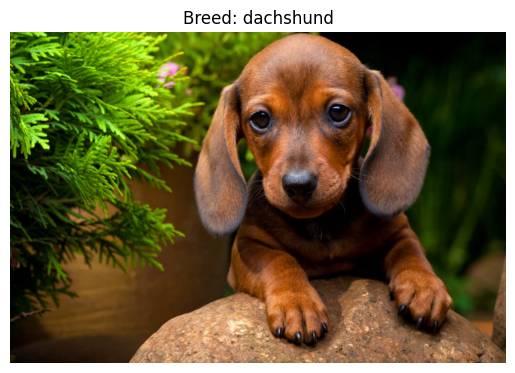

In [ ]:
import random
from PIL import Image

# Select a random breed folder
random_breed_dbi = random.choice(os.listdir(train_dir_dbi))
breed_path_dbi = os.path.join(train_dir_dbi, random_breed_dbi)

# Select a random image from the breed folder
random_image_dbi = random.choice(os.listdir(breed_path_dbi))
image_path_dbi = os.path.join(breed_path_dbi, random_image_dbi)

# Fixing: Ensure it's a file, not a directory
while os.path.isdir(image_path_dbi):
    random_image_dbi = random.choice(os.listdir(breed_path_dbi))
    image_path_dbi = os.path.join(breed_path_dbi, random_image_dbi)

# Open and display image
img = Image.open(image_path_dbi)
plt.imshow(img)
plt.title(f"Breed: {random_breed_dbi}")
plt.axis("off")
plt.show()


## Keep the 7 common breeds

In [28]:
import os
import shutil

def process_sdd(path_sdd):
    """
    Process the Stanford Dogs Dataset (SDD) by:
    - Keeping only 7 required breeds
    - Renaming breed folders to match DBI
    - Moving them to 'SDDsubset'
    - Zipping the processed dataset
    - Uploading to Google Drive
    """

    # Define the subset destination
    sdd_subset_path = "/root/SDDsubset"
    os.makedirs(sdd_subset_path, exist_ok=True)

    # Mapping SDD breed names to standardized format
    rename_dict = {
        "n02107683-Bernese_mountain_dog": "bernese_mountain_dog",
        "n02106166-Border_collie": "border_collie",
        "n02085620-Chihuahua": "chihuahua",
        "n02099601-golden_retriever": "golden_retriever",
        "n02099712-Labrador_retriever": "labrador_retriever",  # Standardized
        "n02110958-pug": "pug",
        "n02110185-Siberian_husky": "siberian_husky"
    }

    # Process only the selected breeds
    for old_name, new_name in rename_dict.items():
        old_path = os.path.join(path_sdd, old_name)
        new_path = os.path.join(sdd_subset_path, new_name)

        if os.path.exists(old_path):
            shutil.move(old_path, new_path)
            print(f"Renamed & moved {old_path} → {new_path}")
        else:
            print(f"Warning: {old_name} not found in SDD!")

    # Zip the processed dataset
    shutil.make_archive("/root/SDDsubset", 'zip', sdd_subset_path)
    print("✅ SDDsubset zipped successfully.")

    # Upload to Google Drive
    drive.mount('/content/drive', force_remount=True)
    shutil.move("/root/SDDsubset.zip", "/content/drive/MyDrive/SDDsubset.zip")
    print("✅ SDDsubset uploaded to Google Drive!")

process_sdd(path_sdd)

✅ SDDsubset zipped successfully.
Mounted at /content/drive
✅ SDDsubset uploaded to Google Drive!


In [29]:
def process_dbi(path_dbi):
    """
    Process the Dog Breed Images (DBI) dataset by:
    - Keeping only 7 required breeds
    - Renaming 'labrador' to 'labrador_retriever'
    - Moving them to 'DBIsubset'
    - Zipping the processed dataset
    - Uploading to Google Drive
    """

    # Define the subset destination
    dbi_subset_path = "/root/DBIsubset"
    os.makedirs(dbi_subset_path, exist_ok=True)

    # List of required breed folders
    breeds_to_keep = [
        "bernese_mountain_dog",
        "border_collie",
        "chihuahua",
        "golden_retriever",
        "labrador",  # This will be renamed to "labrador_retriever"
        "pug",
        "siberian_husky"
    ]

    # Move and rename breeds
    for breed in breeds_to_keep:
        old_path = os.path.join(path_dbi, breed)
        new_path = os.path.join(dbi_subset_path, "labrador_retriever" if breed == "labrador" else breed)

        if os.path.exists(old_path):
            shutil.move(old_path, new_path)
            print(f"Moved {old_path} → {new_path}")
        else:
            print(f"Warning: {breed} not found in DBI!")

    # Zip the processed dataset
    shutil.make_archive("/root/DBIsubset", 'zip', dbi_subset_path)
    print("✅ DBIsubset zipped successfully.")

    # Upload to Google Drive
    drive.mount('/content/drive', force_remount=True)
    shutil.move("/root/DBIsubset.zip", "/content/drive/MyDrive/DBIsubset.zip")
    print("✅ DBIsubset uploaded to Google Drive!")

process_dbi(path_dbi)

✅ DBIsubset zipped successfully.
Mounted at /content/drive
✅ DBIsubset uploaded to Google Drive!


In [25]:
print(os.listdir("/root/SDDsubset"))  # Should list 7 breed folders, including "labrador_retriever"
print(os.listdir("/root/DBIsubset"))  # Should list 7 breed folders, including "labrador_retriever"


['chihuahua', 'pug', 'labrador_retriever', 'border_collie', 'bernese_mountain_dog', 'golden_retriever', 'siberian_husky']
['chihuahua', 'pug', 'border_collie', 'bernese_mountain_dog', 'golden_retriever', 'labrador', 'siberian_husky']


In [ ]:
len(dataset)

In [ ]:
len(dataset.classes)

In [ ]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(rename(n))

## Creating training, validation and testing dataset

In [ ]:
random_seed = 45
torch.manual_seed(random_seed);

In [ ]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

In [ ]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

## Creating Custom Dataset

To create our custom Dataset, we need to extend Pytorch's `Dataset` class.
We need to implement 3 methods inside our Custom Dataset Class:

1. `__init__`
2. `__len__`
3. `__getitem__`

In [ ]:
class DogBreedDataset(Dataset):

    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)
            return img, label

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)

])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [ ]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

Lets quickly take a look into our training dataset

In [ ]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

Now we will create Training , validation data and test data loader

In [ ]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

We can also take a peek into our dataset by creating grid of images using Pytorch's `make_grid()` method.

In [ ]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

In [ ]:
show_batch(train_dl)

## Network Architecture

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss

    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}

    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))


In [ ]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),   # 224 * 244 * 32
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 32

            nn.Conv2d(32, 64, 3, stride=1, padding=1),   # 112 * 112* 64
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),    # 112 * 112* 128
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 128

            nn.Conv2d(128, 256, 3, stride=1, padding=1),   # 56*56*256
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),  # 56*56*256
            nn.ReLU(),
            nn.MaxPool2d(2,2),                        # 28*28*256

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 14*14*256

            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 7*7*256

            nn.Flatten(),
            nn.Linear(7*7*256, 512),
            nn.ReLU(),
            nn.Linear(512, 120),
            nn.LogSoftmax(dim = 1),
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = DogBreedClassificationCNN()
model

Let's define ResNet-34 Pre-trained model

In [ ]:
class DogBreedPretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model2 = DogBreedPretrainedResnet34()
model2

### Let's now use some more pre-trained models

Inception V3

In [ ]:
class DogBreedPretrainedInceptionV3(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.inception_v3(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
# model3 = DogBreedPretrainedInceptionV3()
# model3

Resnet 152

In [ ]:
class DogBreedPretrainedResnet152(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.resnet152(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model4 = DogBreedPretrainedResnet152()
model4

VGG16

In [ ]:
class DogBreedPretrainedVGG16(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.vgg16(pretrained=True)
        # Replace last layer
        self.network.classifier = nn.Sequential(
           nn.Linear(in_features=25088, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.5, inplace=False),
           nn.Linear(in_features=4096, out_features=4096, bias=True),
           nn.ReLU(inplace=True),
           nn.Dropout(p=0.5, inplace=False),
           nn.Linear(in_features=4096, out_features=120, bias=True),
           nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model5 = DogBreedPretrainedVGG16()
model5

GoogleNet

In [ ]:
class DogBreedPretrainedGoogleNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.googlenet(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model6 = DogBreedPretrainedGoogleNet()
model6

DenseNet

In [ ]:
class DogBreedPretrainedDenseNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.densenet161(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier.in_features
        self.network.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model7 = DogBreedPretrainedDenseNet()
model7

Wide ResNet-50-2

In [ ]:
class DogBreedPretrainedWideResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()

        self.network = models.wide_resnet50_2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model1 = DogBreedPretrainedWideResnet()
model1

## Moving Data to GPU

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [ ]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# moving model to gpu
to_device(model, device);

## Training

In [ ]:
# check the model
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model1(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break

try_batch(train_dl)

Now we'll train the model

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        # Training phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)

            # calculates gradients
            loss.backward()

            # check gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # perform gradient descent and modifies the weights
            optimizer.step()

            # reset the gradients
            optimizer.zero_grad()

            # record and update lr
            lrs.append(get_lr(optimizer))

            # modifies the lr value
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)


    return history



@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
evaluate(model1, val_dl)                 # change model object here

In [ ]:
# set hyperparams
num_epochs = 5
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
history = fit_one_cycle(num_epochs, max_lr, model1, train_dl, val_dl, weight_decay, grad_clip, opt_func)

In [ ]:
num_epochs = 3
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, model1, train_dl, val_dl, weight_decay, grad_clip, opt_func)

In [ ]:
num_epochs = 2
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, model1, train_dl, val_dl, weight_decay, grad_clip, opt_func)

## Plotting history

In [ ]:
history[0].keys()

In [ ]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

### Loss v/s Epochs plot

In [ ]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### Accuracy v/s Epochs plot

In [ ]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.xlabel('epochs')
plt.ylabel('lr')
plt.plot(lrs)
plt.show()

## Prediction

In [ ]:
def predict_single(img, label):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model1(xb)                   # change model object here
    predictions = preds[0]

    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', breeds[label], ' | Predicted :', breeds[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

In [ ]:
predict_single(*test_dataset[6])

In [ ]:
predict_single(*test_dataset[1])

In [ ]:
predict_single(*test_dataset[93])

In [ ]:
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
result = evaluate(model1, test_dl)
result

## Save model

In [ ]:
weights_fname = 'dog-breed-classifier-wideresnet_with_data_aug.pth'
torch.save(model4.state_dict(), weights_fname)

## Commit to Jovian

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='wideresnet_with_data_aug',
                       epochs=len(history),
                       max_lr_01=0.01,
                       max_lr_02=0.001,
                       max_lr_03=0.0001,
                       scheduler='one-cycle',
                       batch_size = batch_size,
                       weight_decay=weight_decay,
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

In [ ]:
jovian.log_metrics(
    train_loss=history[-1]['train_loss'],
    val_loss=history[-1]['val_loss'],
    val_score=history[-1]['val_acc'],
    test_score=result['val_acc'],
    test_loss=result['val_loss']
)

In [ ]:
project_name='dog-breed-classifier-final'

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=[weights_fname])